# Create a simple tensor with random items

In [ ]:
import numpy as np

# Suppress scientific notation
np.set_printoptions(suppress=True)

# Generate randomly distributed parameters
params = np.random.uniform(low=-50, high=150, size=20)

# Round each number to the second decimal place
params = np.round(params, 2)

# Print the parameters
print(params)

[128.37 139.02  56.96  63.89 140.87 -36.1   62.94 -34.84  87.77 135.91
  17.49   8.79  28.47  40.28  91.2    2.25 125.04 -36.92   7.36  54.1 ]


In [ ]:
params

array([128.37, 139.02,  56.96,  63.89, 140.87, -36.1 ,  62.94, -34.84,
        87.77, 135.91,  17.49,   8.79,  28.47,  40.28,  91.2 ,   2.25,
       125.04, -36.92,   7.36,  54.1 ])

# Define the quantization methods and quantize

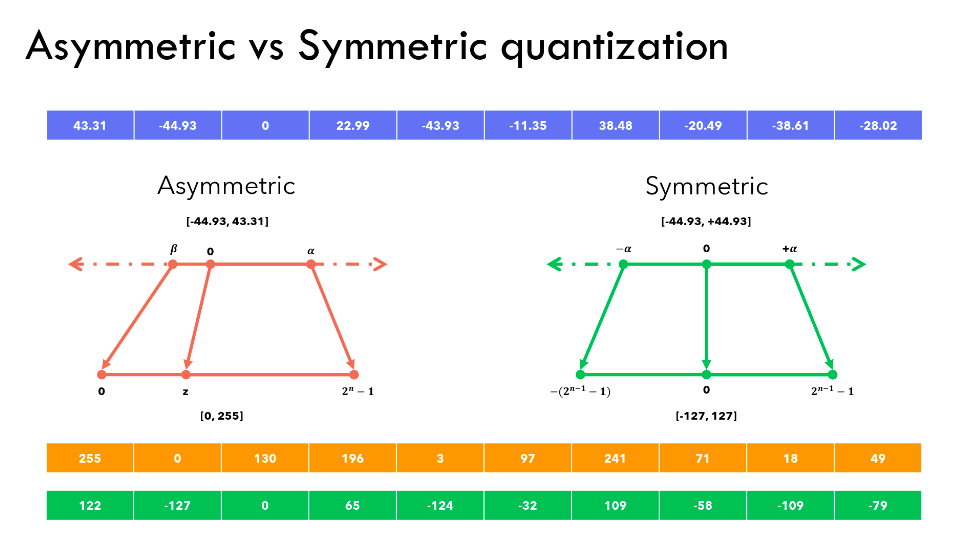

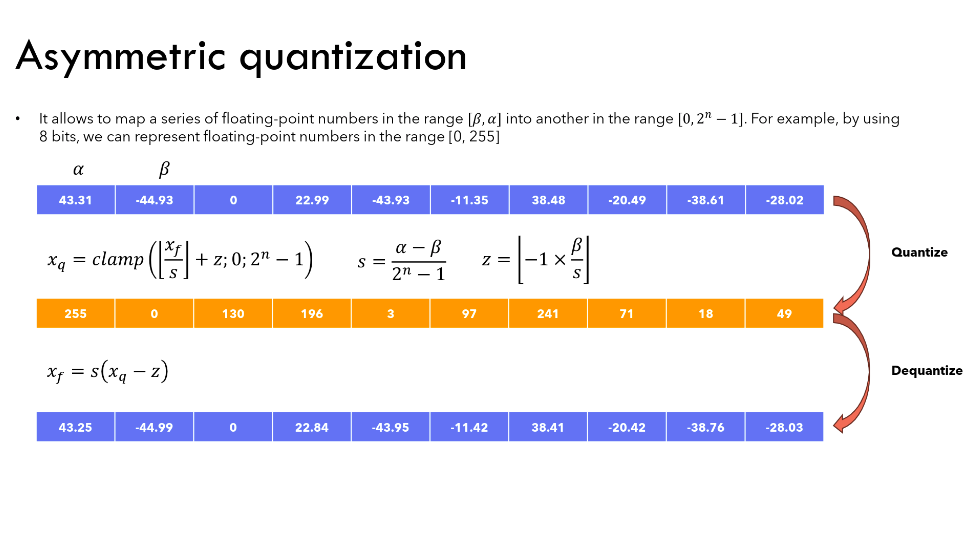

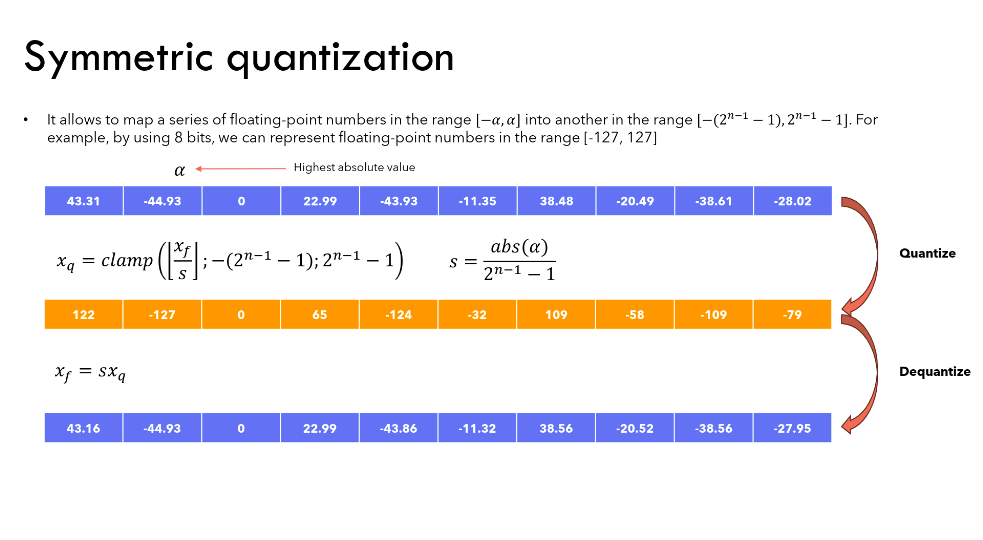

In [ ]:
def clamp(params_q: np.array, lower_bound: int, upper_bound: int) -> np.array:
  params_q[params_q < lower_bound] = lower_bound
  params_q[params_q > upper_bound] = upper_bound
  return params_q

def asymmetric_quantization(params: np.array, bits: int) -> tuple[np.array, float, int]:
  alpha = max(params)
  beta = min(params)
  scale = (alpha - beta) / (2**bits - 1)
  z = -1 * np.round(beta / scale)
  lower_bound, upper_bound = 0, 2**bits-1
  # Quantize the parameters
  quantized_params = clamp(np.round((params / scale) + z), lower_bound, upper_bound).astype(np.int32)
  return quantized_params, scale, z

def asymmetric_dequantize(params_q: np.array, scale: float, z: int) -> np.array:
  return (params_q - z) * scale

def symmetric_dequantize(params_q: np.array, scale: float) -> np.array:
    return params_q * scale

def symmetric_quantization(params: np.array, bits: int) -> tuple[np.array, float]:
  alpha = max(params)
  scale = np.max(np.abs(params)) / (2**(bits - 1) - 1)
  lower_bound, upper_bound = -2**(bits - 1) - 1, 2**(bits -1) - 1
  # Quantize the parameters
  quantized_params = clamp(np.round(params / scale), lower_bound, upper_bound).astype(np.int32)
  return quantized_params, scale

def quantization_error(params: np.array, params_q: np.array):
    # calculate the MSE
    return np.mean((params - params_q)**2)


In [ ]:
(asymmetric_q, asymmetric_scale, asymmetric_zero) = asymmetric_quantization(params, 8)
(symmetric_q, symmetric_scale) = symmetric_quantization(params, 8)

print(f'Original:')
print(np.round(params, 2))
print('')
print(f'Asymmetric scale: {asymmetric_scale}, zero: {asymmetric_zero}')
print(asymmetric_q)
print('')
print(f'Symmetric scale: {symmetric_scale}')
print(symmetric_q)

Original:
[128.37 139.02  56.96  63.89 140.87 -36.1   62.94 -34.84  87.77 135.91
  17.49   8.79  28.47  40.28  91.2    2.25 125.04 -36.92   7.36  54.1 ]

Asymmetric scale: 0.6972156862745099, zero: 53.0
[237 252 135 145 255   1 143   3 179 248  78  66  94 111 184  56 232   0
  64 131]

Symmetric scale: 1.1092125984251968
[116 125  51  58 127 -33  57 -31  79 123  16   8  26  36  82   2 113 -33
   7  49]


In [ ]:
# Dequantize the parameters back to 32 bits
params_deq_asymmetric = asymmetric_dequantize(asymmetric_q, asymmetric_scale, asymmetric_zero)
params_deq_symmetric = symmetric_dequantize(symmetric_q, symmetric_scale)

print(f'Original:')
print(np.round(params, 2))
print('')
print(f'Dequantize Asymmetric:')
print(np.round(params_deq_asymmetric,2))
print('')
print(f'Dequantize Symmetric:')
print(np.round(params_deq_symmetric, 2))

Original:
[128.37 139.02  56.96  63.89 140.87 -36.1   62.94 -34.84  87.77 135.91
  17.49   8.79  28.47  40.28  91.2    2.25 125.04 -36.92   7.36  54.1 ]

Dequantize Asymmetric:
[128.29 138.75  57.17  64.14 140.84 -36.26  62.75 -34.86  87.85 135.96
  17.43   9.06  28.59  40.44  91.34   2.09 124.8  -36.95   7.67  54.38]

Dequantize Symmetric:
[128.67 138.65  56.57  64.33 140.87 -36.6   63.23 -34.39  87.63 136.43
  17.75   8.87  28.84  39.93  90.96   2.22 125.34 -36.6    7.76  54.35]


In [ ]:
# Calculate the quantization error
print(f'{"Asymmetric error: ":>20}{np.round(quantization_error(params, params_deq_asymmetric), 2)}')
print(f'{"Symmetric error: ":>20}{np.round(quantization_error(params, params_deq_symmetric), 2)}')

  Asymmetric error: 0.03
   Symmetric error: 0.11
